Sampling: [a_bar, a_m, b_p, g_mp, sigma_a, sigma_b, sigma_g, theta]


[-2.56143416 -3.09066    -0.32486956  1.87745723 -0.49243845  2.10909992
  1.78967392 -0.20631048 -0.59356783  0.07645492]


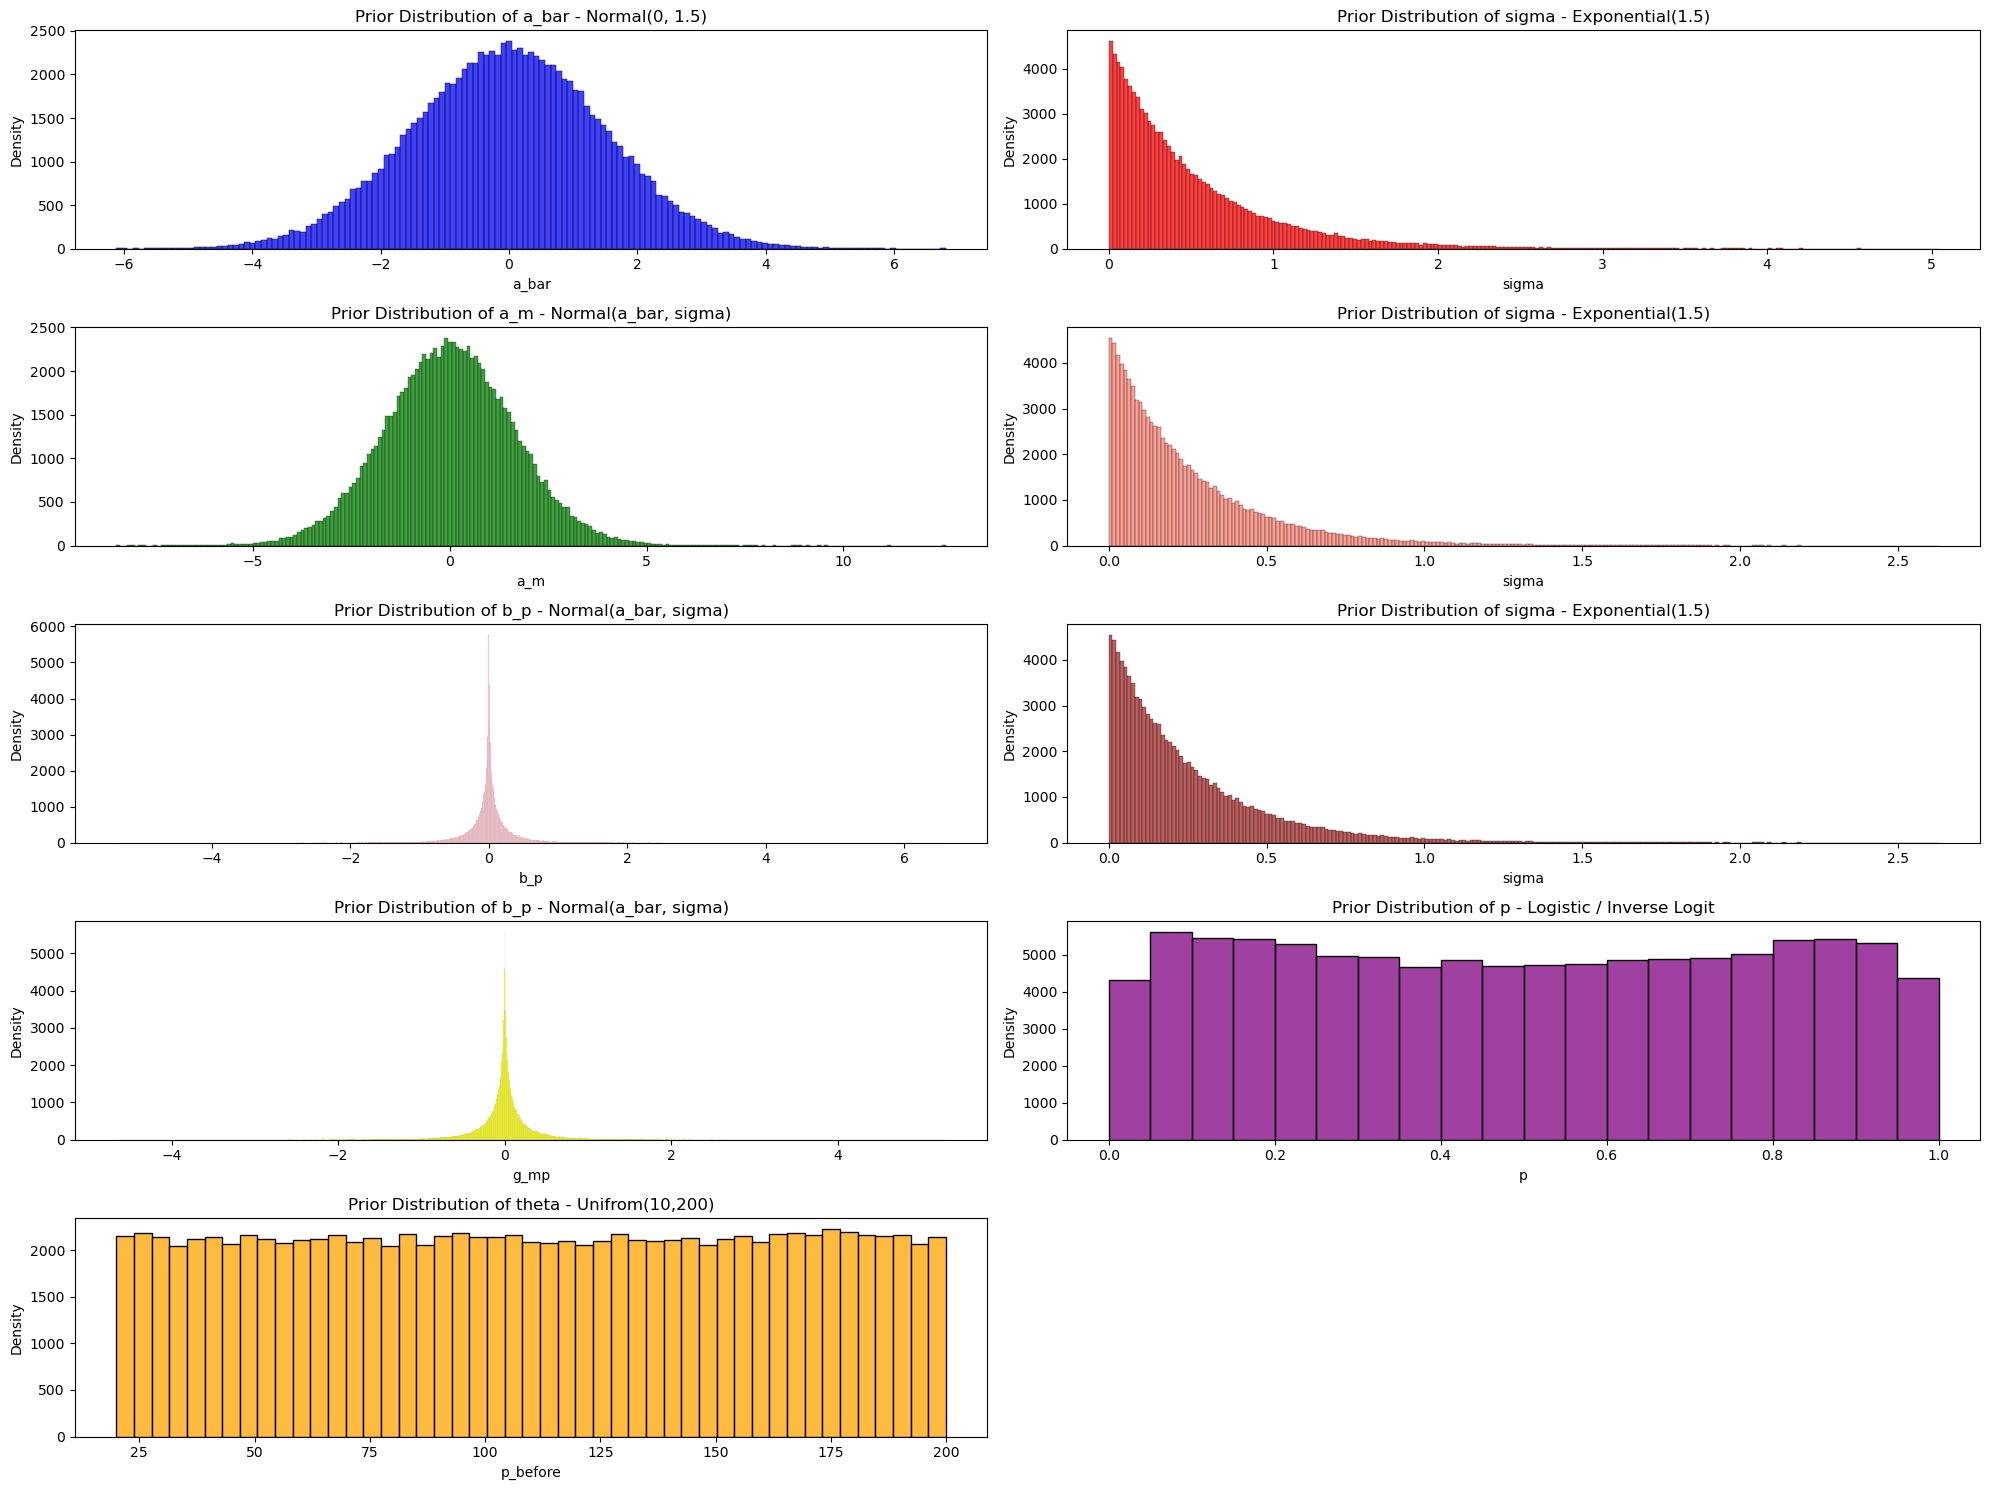

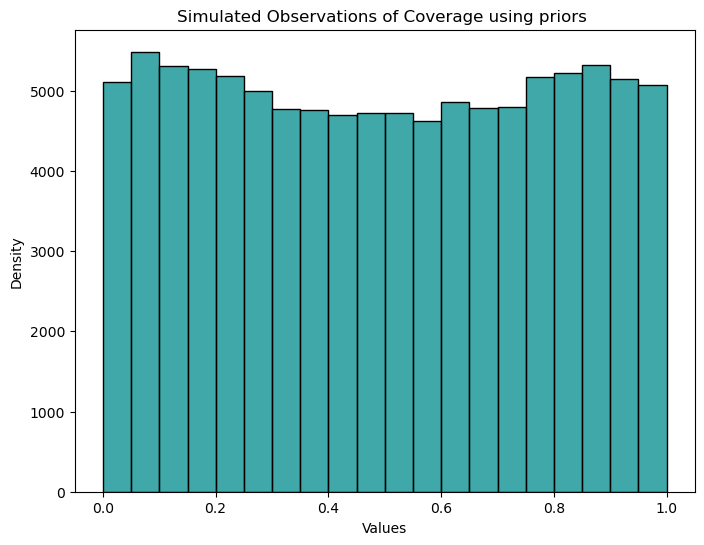

In [4]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard Deviations for Modules, Parameters and Interactions
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Module-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a )

    # Parameter effects
    b_p = pm.Normal('b_p', mu=0, sigma = sigma_b)

    # Interaction effects
    g_mp = pm.Normal('g_mp', mu=0, sigma = sigma_g)
    
    p_before = pm.Deterministic('p_before', (a_m + b_p + g_mp))

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter

    # Sample Priors
    idata = pm.sample_prior_predictive(samples=100000)

# Fetch and flatten priors
prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma_a = idata.prior['sigma_a'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_sigma_b = idata.prior['sigma_b'].values.flatten()
prior_b_p = idata.prior['b_p'].values.flatten()
prior_sigma_g = idata.prior['sigma_g'].values.flatten()
prior_g_mp = idata.prior['g_mp'].values.flatten()
prior_p_before = idata.prior['p_before'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()

print(prior_p_before[0:10])

# Sample one data point from each combinatio0.00001
simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


plt.figure(figsize=(20, 15))

# a_bar
plt.subplot(5, 2, 1)
sns.histplot(prior_a_bar, color='blue')
plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
plt.xlabel('a_bar')
plt.ylabel('Density')

# sigma
plt.subplot(5, 2, 2)
sns.histplot(prior_sigma_a, color='red')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# a_m
plt.subplot(5, 2, 3)
sns.histplot(prior_a_m, color='green')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('a_m')
plt.ylabel('Density')

# sigma
plt.subplot(5, 2, 4)
sns.histplot(prior_sigma_b, color='salmon')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# b_p
plt.subplot(5, 2, 5)
sns.histplot(prior_b_p, color='pink')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('b_p')
plt.ylabel('Density')

# sigma
plt.subplot(5, 2, 6)
sns.histplot(prior_sigma_b, color='brown')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# g_mp
plt.subplot(5, 2, 7)
sns.histplot(prior_g_mp, color='yellow')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('g_mp')
plt.ylabel('Density')

# p
plt.subplot(5, 2, 8)
sns.histplot(prior_p, bins=np.arange(0, 1.05, 0.05), color='purple')
plt.title('Prior Distribution of p - Logistic / Inverse Logit')
plt.xlabel('p')
plt.ylabel('Density')

# theta
plt.subplot(5, 2, 9)
sns.histplot(prior_theta, color='orange')
plt.title('Prior Distribution of theta - Unifrom(10,200)')
plt.xlabel('p_before')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Predicated observations
plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
plt.title('Simulated Observations of Coverage using priors ')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()


# Interactive sliders
#interact(calc_prior_dist, a=(0.01, 5.0, 0.01), b=(0.01, 5.0, 0.01), g=(0.01, 5.0, 0.01))

In [10]:
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Select columns for the coverage timeline
coverage_data = data.filter(regex='^CoverageTimeline_T')

# Calculate the integral for each row using the trapezoidal rule
data['IntegralValue'] = coverage_data.apply(lambda row: np.trapz(row, dx=1), axis=1)
data['IntegralValue'] = data['IntegralValue'] / 300.0



In [12]:
import formulaic
import pymc as pm
import pandas as pd

#data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")

# Dummy variables for Module and Parameters
model_formula = 'IntegralValue ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'IntegralValue ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]



In [14]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard Deviations for Modules, Parameters and Interactions
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Non-centered parameterizations
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=design_matrix.lhs['IntegralValue'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, sigma_g, a_offset, b_offset, g_offset, theta]


Output()

ValueError: Not enough samples to build a trace.